<a href="https://colab.research.google.com/github/wesleydatavant/datascience/blob/main/notebooks/thompson_sampling_univariate.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Univariate Thompson Sampling, with Pokemon!

<br>

---

<br>

In this project notebook we'll be exploring the multi armed bandit problem with thompson sampling.

Read more [here](https://arxiv.org/pdf/1707.02038.pdf)

<br>

---

## Imports

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.spatial.distance import cdist
from haversine import haversine, Unit
from math import isclose
import random

import scipy
import scipy.stats as stats
from scipy.stats import betabinom, beta, binom, norm

pd.set_option('display.max_rows', 500)

## Problem Overview

You’re hunting for Pokemon in some forested area outside of Pewter City, divided into four regions. You know that in each region, the probability of finding one of either Charmander, Bulbasaur or Pikachu willl vary. Given a region, which pokemon are we most likely to find?

<center>
<img src="https://raw.githubusercontent.com/wesleydatavant/datascience/main/notebooks/static/Routing_%20Model%20Development%208.19.22.jpeg" width=600px></img>
</center>

Intuitively, we would expect distances between regions to have some relationship with the similarity in probability distributions.

For the purpose of demonstrating the algorithm, imagine that you are going to spend many iterations searching through each region, and every time you search a region you can only check for one of the three pokemon. 

## Setup

Before we dive into this problem we've specified, let's talk about our building blocks. The first building block will be the beta distribution. A beta distribution describes a probability of probabilities. In short, it estimates the expected reward from a binomial distribution. Which is perfect for us, because when we search for a Pokemon we either find it (success, 1) or don't find it (failure, 0). The outcome of many searches allows us to parmaterize a beta distribution for every pokemon for every region. The number of times we successfully find a pokemon is taken as the value of alpha for the beta distribution, its first parameter; and the number of times we unsuccessfully search for a pokemon in a region is taken as the value of beta for the beta distribution, its second parameter.

### Beta Binomial Model

Below is an example of building a binomial distribution to sample from, given a historical record of how many succcesses (alpha, or pokemon found) and failures (beta, or pokemon not found) in the region:

In [856]:
n = 1 # number of outcomes + 1
a = 12 # number of succcess
b = 8 # number of fail

# alpha and beta are used to estimate the distribution
dist = betabinom(n=n,
                a=a,
                b=b)

# we can then sample from this parameterized beta-binomial model
dist.rvs(size=10)

array([1, 0, 1, 1, 1, 0, 0, 0, 0, 0])

We can also take this parameterized binomial distribution and plot the probability mass function:

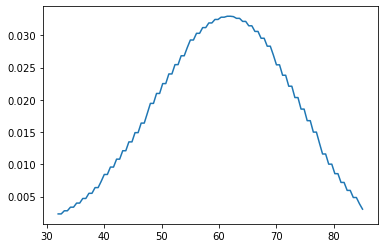

In [857]:
n = 100
x = np.linspace(betabinom.ppf(0.01, n, a, b),
                betabinom.ppf(0.99, n, a, b), 100)
y = betabinom.pmf(x, n, a, b)
fig, ax = plt.subplots()
ax.plot(x, y)
# ax.set_ylim(0,1)

### Beta Model

When we start talking about Thompson Sampling, we will not be sampling from the binomial distributions themselves. Rather, we will sample from the _beta_ distribution that represents what would be a reasonable expectation of average success rate for finding each of the pokemon. The beta distribution for three pokemon is represented below. In the following example we would expect to prioritize sampling Bulbasaur but also expect to find Pikachu in the area.

Text(0.5, 1.0, 'Estimated Rewards for Pokemon in Region A outside of Pewter City')

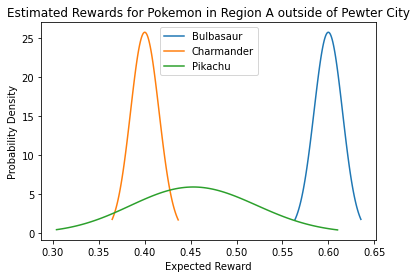

In [858]:
# one region outside of Pewter City
fig, ax = plt.subplots()

params = np.array([[601, 401], # pokemon A (Bublasaur)
                  [401, 601], # pokemon B (Charmander)
                  [25, 30]]) # pokemon C (Pikachu)
pokemon = ["Bulbasaur", "Charmander", "Pikachu"]

for param, name in zip(params, pokemon):
    a = param[0]
    b = param[1]
    x = np.linspace(beta.ppf(0.01, a, b),
                beta.ppf(0.99, a, b), 100)
    y = beta.pdf(x, a, b)
    ax.plot(x, y, label=name)
ax.legend()
ax.set_xlabel("Expected Reward")
ax.set_ylabel("Probability Density")
ax.set_title("Estimated Rewards for Pokemon in Region A outside of Pewter City")

## First Simulation: One Region, Three Pokemon

Before we tackle the four region problem, let's consider just a single region and how the Thompson Sampling (TS) algorithm would work in this context.

For every step in the TS algorithm:

1. Estimate univariate beta distributions (one for each Pokemon)
2. Sample from every beta distribution and select the pokemon with the maximum reward
3. Search for the selected Pokemon, update it's beta parameters

$$
  (\alpha_k, \beta_k) = \left \{
  \begin{aligned}
    &(\alpha_k, \beta_k) + (r_t, 1-r_t), && \text{if}\ x_t = k \\
    &(\alpha_k, \beta_k), && \text{otherwise}
  \end{aligned} \right.
$$

where \\(r_t\\) refers to the outcome of the action taken this time step and is 1 if the action was successful and 0 otherwise; \\(k\\) are the available Pokemon (sometimes referred to as actions); and \\(x_t\\) is the Pokemon (action) selected at time step, \\(t\\).

Before moving forward, let's create a "ground truth" that we will call `true_charts` of where the Pokemon will be at each time step (each time we search the region):

[Text(0, 0, 'Bulbasaur'), Text(1, 0, 'Charmander'), Text(2, 0, 'Pikachu')]

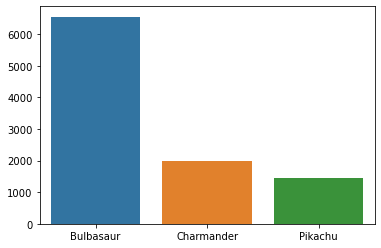

In [859]:
num_searches = 10000
params = np.array([[601, 401], # pokemon A (Bublasaur)
                  [401, 601], # pokemon B (Charmander)
                  [25, 30]]) # pokemon C (Pikachu)
dist = betabinom(1, params[:, 0], params[:, 1])
true_charts = []
for t in range(num_searches):
    exp = dist.rvs()
    if exp.sum() == exp.shape[0]:
        choice = np.random.randint(exp.shape[0])
    else:
        choice = np.argmax(exp)
    true_charts.append(choice)
    
sums = pd.Series.value_counts(true_charts)
sums = pd.DataFrame(sums).T

fig, ax = plt.subplots()
sns.barplot(data=sums, ax=ax)
ax.set_xticklabels(pokemon)

### TS Approach

In [860]:
# params represents the success (alpha) and failure (beta)
# of each pokemon based on historical performances
params = np.array([[1, 1], # pokemon A
                  [1, 1], # pokemon B
                  [1, 1]]) # pokemon C

# pokemon_names = ["Pokemon 1", "Pokemon 2", "Pokemon 3"]

# we are simulating 10,000 record searches and assuming
# the record is either in pokemon A, B, C or none of them
for request in range(num_searches):
    best = 0
    best_idx = 0
    
    for idx, param in enumerate(params):
        
        # note that we sample from beta and not binomial - we are sampling
        # a reasonable expectation of success, not the outcome (0, 1) were
        # the pokemon to be selected
        a = param[0]
        b = param[1]
        sample = beta.rvs(a, b)
        
        if sample > best:
            best = sample
            best_idx = idx
        else:
            pass # did not beat best
        
    # update alpha/beta for selected
    if true_charts[request] == best_idx:
        params[best_idx][0] += 1
    else:
        params[best_idx][1] += 1

In [861]:
print(f"successes: {sum(params[:,0])/sum(sum(params))*100:.1f}%")
print(f"failures: {sum(params[:,1])/sum(sum(params))*100:.1f}%")

successes: 65.4%
failures: 34.6%


Text(0, 0.5, 'Probability Density')

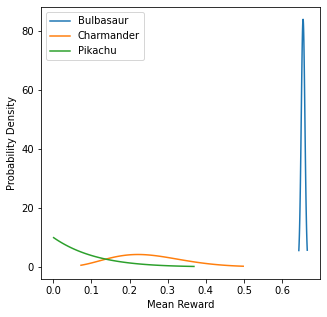

In [862]:
fig, ax = plt.subplots(figsize=(5,5))
for name, param in zip(pokemon, params):
    a = param[0]
    b = param[1]
    x = np.linspace(beta.ppf(0.01, a, b),
                beta.ppf(0.99, a, b), 100)
    y = beta.pdf(x, a, b)
    plt.plot(x, y, label=name)
plt.legend()
ax.set_xlabel("Mean Reward")
ax.set_ylabel("Probability Density")

### Greedy Approach

We can also compare this with a greedy algorithm, where we always select the action with the highest expected reward (i.e. we do not sample)

In [863]:
params = np.array([[1, 1], # pokemon A
                  [1, 1], # pokemon B
                  [1, 1]]) # pokemon C

for request in range(total_requests):
    
    best_idx = np.argmax(params[:,0] / params[:,1])
    if true_charts[request] == best_idx:
        params[best_idx][0] += 1
    else:
        params[best_idx][1] += 1

In [864]:
print(f"successes: {sum(params[:,0])/sum(sum(params))*100:.1f}%")
print(f"failures: {sum(params[:,1])/sum(sum(params))*100:.1f}%")

successes: 65.6%
failures: 34.4%


Text(0, 0.5, 'Probability Density')

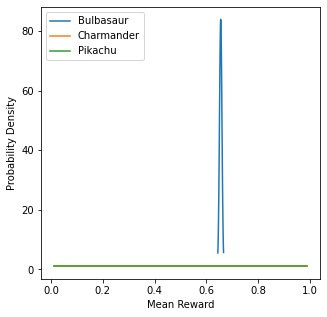

In [865]:
fig, ax = plt.subplots(figsize=(5,5))
for name, param in zip(pokemon, params):
    a = param[0]
    b = param[1]
    x = np.linspace(beta.ppf(0.01, a, b),
                beta.ppf(0.99, a, b), 100)
    y = beta.pdf(x, a, b)
    plt.plot(x, y, label=name)
plt.legend()
ax.set_xlabel("Mean Reward")
ax.set_ylabel("Probability Density")

## Second Simulation: One Region, Ten Pokemon

Let's now see how the algorithm would work expanding to 10 possible pokemon in the given region

In [866]:
num_pokemon = 10

np.random.seed(42)
pokemon_expectations = np.random.random(num_pokemon)

true_charts = np.zeros(shape=10000)
for pokemon in pokemon_expectations:
    pokemon = norm(loc=pokemon, scale=1)
    true_charts = np.vstack((true_charts, pokemon.rvs(10000)))
true_charts = true_charts[1:,:]
true_charts = np.argmax(true_charts, axis=0)

rank_order_pokemons = pd.Series.value_counts(true_charts).index
pokemon_names = [f"Pokemon {i+1}" for i in rank_order_pokemons]

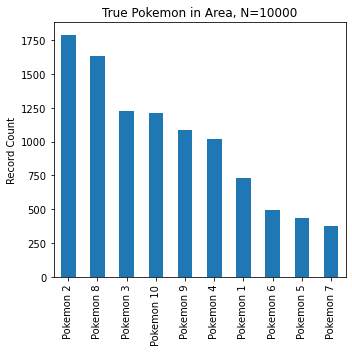

In [867]:
fig, ax = plt.subplots(figsize=(5,5))
pd.Series.value_counts(true_charts).plot(kind='bar')
plt.title(f"True Pokemon in Area, N={len(true_charts)}")
plt.xticks(range(num_pokemon), labels=pokemon_names)
ax.set_ylabel("Record Count")
plt.tight_layout()

### TS Approach

In [868]:
# params represents the success (alpha) and failure (beta)
# of each pokemon based on historical performances
num_pokemon = 10
params = np.ones(shape=(num_pokemon, 2))

pokemon_names = [f"Pokemon {i+1}" for i in range(num_pokemon)]

# we are simulating 10,000 record searches and assuming
# the record is either in pokemon A, B, C or none of them
for request in range(total_requests):
    best = 0
    best_idx = 0
    
    for idx, param in enumerate(params):
        
        # note that we sample from beta and not binomial - we are sampling
        # a reasonable expectation of success, not the outcome (0, 1) were
        # the pokemon to be selected
        a = param[0]
        b = param[1]
        sample = beta.rvs(a, b)
        
        if sample > best:
            best = sample
            best_idx = idx
        else:
            pass # did not beat best
        
    # update alpha/beta for selected
    if true_charts[request] == best_idx:
        params[best_idx][0] += 1
    else:
        params[best_idx][1] += 1

In [869]:
print(f"successes: {sum(params[:,0])/sum(sum(params))*100:.1f}%")
print(f"failures: {sum(params[:,1])/sum(sum(params))*100:.1f}%")

successes: 17.1%
failures: 82.9%


Text(0, 0.5, 'Probability Density')

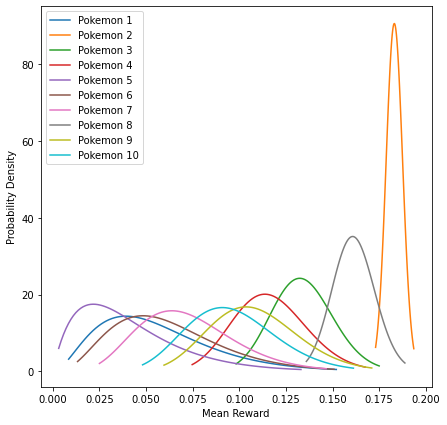

In [870]:
fig, ax = plt.subplots(figsize=(7,7))
for name, param in zip(pokemon_names, params):
    a = param[0]
    b = param[1]
    x = np.linspace(beta.ppf(0.01, a, b),
                beta.ppf(0.99, a, b), 100)
    y = beta.pdf(x, a, b)
    plt.plot(x, y, label=name)
plt.legend(loc=2)
ax.set_xlabel("Mean Reward")
ax.set_ylabel("Probability Density")

### Greedy Approach

This will be the last time we compare with the greedy solution.

In [871]:
num_pokemon = 10
params = np.ones(shape=(num_pokemon, 2))

pokemon_names = [f"Pokemon {i+1}" for i in range(num_pokemon)]

for request in range(total_requests):
    
    best_idx = np.argmax(params[:,0] / params[:,1])
    if true_charts[request] == best_idx:
        params[best_idx][0] += 1
    else:
        params[best_idx][1] += 1

In [872]:
print(f"successes: {sum(params[:,0])/sum(sum(params))*100:.1f}%")
print(f"failures: {sum(params[:,1])/sum(sum(params))*100:.1f}%")

successes: 16.2%
failures: 83.8%


Text(0, 0.5, 'Probability Density')

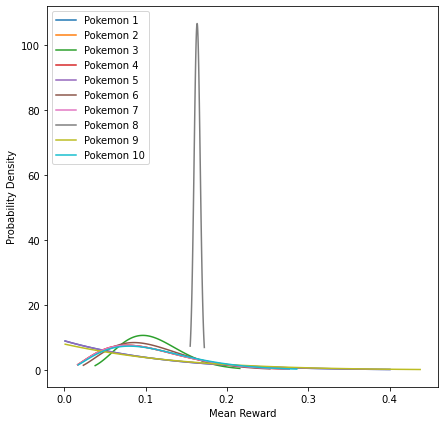

In [873]:
fig, ax = plt.subplots(figsize=(7,7))
for name, param in zip(pokemon_names, params):
    a = param[0]
    b = param[1]
    x = np.linspace(beta.ppf(0.01, a, b),
                beta.ppf(0.99, a, b), 100)
    y = beta.pdf(x, a, b)
    plt.plot(x, y, label=name)
plt.legend(loc=2)
ax.set_xlabel("Mean Reward")
ax.set_ylabel("Probability Density")

## Third Simulation: Four Regions, Three Pokemon

In this third simulation, we will tackle the original problem we scoped in the beginning:


> You’re hunting for Pokemon in some forested area outside of Pewter City, divided into four regions. You know that in each region, the probability of finding one of either Charmander, Bulbasaur or Pikachu willl vary. If we are looking for one Pokemon in particular, let's say Charmander (we love Charmander), which region should you head to, to maximize the probability of finding Charmander?

In this problem, we want to take into consideration the probabilities of surrounding regions. 

> For a practical example of prior selection, let us revisit the banner
ad placement problem introduced in Example 1.1. There are K banner
ads for a single product, with unknown click-through probabilities
(θ1, . . . , θK). Given a prior, TS can learn to select the most successful
ad. We could use a uniform or, equivalently, a beta(1, 1) distribution over
each θk. However, if some values of θk are more likely than others, using a
uniform prior sacrifices performance. In particular, this prior represents
no understanding of the context, ignoring any useful knowledge from
past experience. Taking knowledge into account reduces what must be
learned and therefore reduces the time it takes for TS to identify the
most effective ads.

[TS paper](https://arxiv.org/pdf/1707.02038.pdfhttps://arxiv.org/pdf/1707.02038.pdf)

### DistanceContext

We will leverage the known distances between regions 

In [998]:
def haversine_vectorized(x, y):
    """
    Vectorized haversine formual will work with arrays of long/lat coordinates
    
    Parameters
    ----------
    x : array, shape=(n_samples_1, 2)
      the first list of coordinates (degrees)
    y : array: shape=(n_samples_2, 2)
      the second list of coordinates (degress)
    Returns
    -------
    d : array, shape=(n_samples_1, n_samples_2)
      the distance between corrdinates (km)
    """
    EARTH_RADIUS = 3958.76
    
    # convert all latitudes/longitudes from decimal degrees to radians
    x_rad = np.radians(x)
    y_rad = np.radians(y)

    # unpack latitude/longitude
    x_lat, x_lng = x_rad[:, 0], x_rad[:, 1]
    y_lat, y_lng = y_rad[:, 0], y_rad[:, 1]

    # broadcast, can also use np.expand_dims
    x_lat = x_lat[None, :]
    x_lng = x_lng[None, :]
    y_lat = y_lat[:, None]
    y_lng = y_lng[:, None]

    # calculate haversine
    d_lat = y_lat - x_lat
    d_lng = y_lng - x_lng

    a = (np.sin(d_lat / 2.0) ** 2
         + np.cos(x_lat) * np.cos(y_lat) * np.sin(d_lng / 2.0) ** 2)

    return 2 * EARTH_RADIUS * np.arcsin(np.sqrt(a))

def get_city_center(city='Pewter'):
    """
    returns coordinates of the city center
    """
    city_json = {"city":{"4":"Pewter","5":"Cerulean","33":"Vermilion","55":"Saffron"},
               "lat":{"4":32.7935,"5":29.786,"33":30.3005,"55":32.7817},
               "lng":{"4":-96.7667,"5":-95.3885,"33":-97.7522,"55":-97.3474}}
    df = pd.DataFrame(city_json)
    lat_lng = df.loc[df['city'] == city, ['lat', 'lng']].iloc[0].values
    return lat_lng

def get_max_lng_lat(lat_lng, km_max=50):
    """
    returns the maximum radius in degrees to obtain a given maximum distance from city center in km
    """
    lat_lng_max = 3
    radius_idx = np.argwhere(
        np.isclose(
            haversine_vectorized(lat_lng[None,:], 
                                (lat_lng[:,None]+np.linspace(0, lat_lng_max, 1000)).T).reshape(-1), 
            km_max, 
            rtol=0.1))[0,0]
    lat_lng_max = np.linspace(0, lat_lng_max, 1000)[radius_idx]
    return lat_lng_max

def get_distance_matrix(lat_lng_max, num_targets=15, seed=None):
    """
    returns an array of coordinates
    """
    if seed:
        np.random.seed(seed)
    r = lat_lng_max * np.sqrt(np.random.random(num_targets))
    theta = np.random.random(num_targets) * 2 * np.pi
    x = lat_lng[0] + r * np.cos(theta)
    y = lat_lng[1] + r * np.sin(theta)
    site_lng_lat = np.concatenate((x[:,None],y[:,None]), axis=1)
    return site_lng_lat

First we compute the distance matrix

In [999]:
# SIM SETUP
num_pokemon = 3
num_regions = 4

lat_lng = get_city_center('Pewter')
lat_lng_max = get_max_lng_lat(lat_lng, km_max=50)
pokemon = get_distance_matrix(lat_lng_max, num_targets=num_pokemon, seed=12)
regions = get_distance_matrix(lat_lng_max, num_targets=num_regions, seed=10)

region_region_matrix = haversine_vectorized(regions, regions)
pokemon_region_matrix = haversine_vectorized(pokemon, regions)

ground_coef_matrix = pd.DataFrame((1 - pokemon_region_matrix/pokemon_region_matrix.max()))
context_coef_matrix = pd.DataFrame((1 - region_region_matrix/region_region_matrix.max()))

We have region to region distances

Text(24.0, 0.5, 'region center')

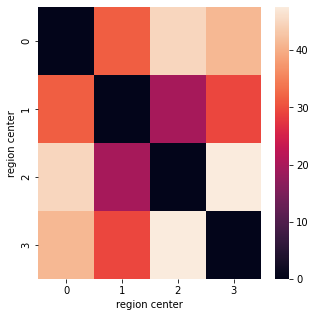

In [1000]:
fig, ax = plt.subplots(figsize=(5,5))
sns.heatmap(pd.DataFrame(region_region_matrix))
ax.set_xlabel("region center")
ax.set_ylabel("region center")

As well as pokemon density center to region distances

Text(24.0, 0.5, 'region center')

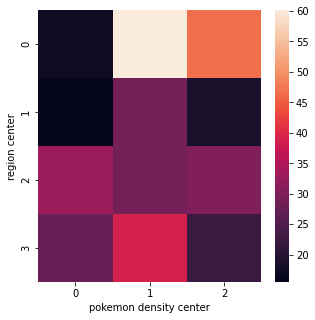

In [1001]:
fig, ax = plt.subplots(figsize=(5,5))
sns.heatmap(pd.DataFrame(pokemon_region_matrix))
ax.set_xlabel("pokemon density center")
ax.set_ylabel("region center")

Create an inverse mapping from 0 to 1 based on each of these matrices

Text(24.0, 0.5, 'region')

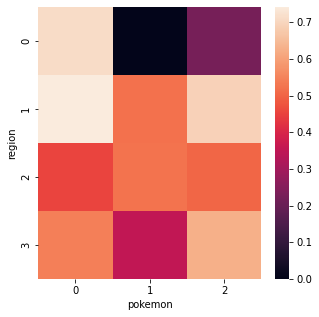

In [1002]:
fig, ax = plt.subplots(figsize=(5,5))
sns.heatmap(ground_coef_matrix)
ax.set_xlabel("pokemon")
ax.set_ylabel("region")

Text(24.0, 0.5, 'region')

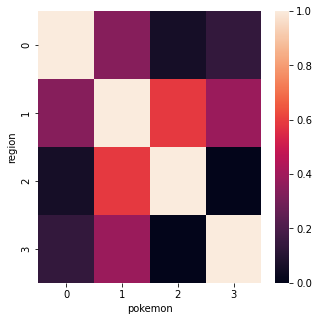

In [1003]:
fig, ax = plt.subplots(figsize=(5,5))
sns.heatmap(context_coef_matrix)
ax.set_xlabel("region")
ax.set_ylabel("region")

### Ground Truth

A little more involved than before since we are dealing with spatial relationships and many regions

`spatial_pokemon_expectations` will contain the expected success rate for each pokemon according to each local region

Text(0.5, 1.0, 'Mean Reward for Pokemons w.r.t Region')

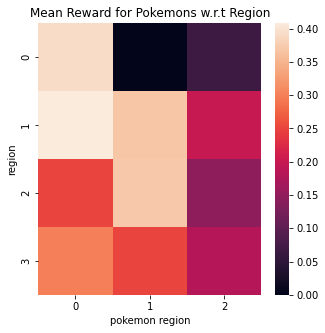

In [1004]:
np.random.seed(3)
num_searches = 100000 # the number of searches per region
pokemon_names = [f"Pokemon {i}" for i in range(num_pokemon)]
region_name = [f"Region {i}" for i in range(num_regions)]

pokemon_expectations = np.random.random(num_pokemon) # an overall expected performance for each pokemon
spatial_pokemon_expectations = ground_coef_matrix * pokemon_expectations
dists = norm(loc=spatial_pokemon_expectations, scale=0.5)
samples = dists.rvs((num_searches, num_regions, num_pokemon))
true_charts = np.argmax(samples, axis=2)

fig, ax = plt.subplots(figsize=(5,5))
sns.heatmap(spatial_pokemon_expectations)
ax.set_xlabel("pokemon region")
ax.set_ylabel("region")
ax.set_title("Mean Reward for Pokemons w.r.t Region")

Once we have the ground truth, we must also compute the `best possible` expected performance for each region, if we were to only choose the dominant pokemon for each one

In [1005]:
max_exp_greedy = []
print("Maximum Expectation for Each Region", end="\n\n")
for i in range(num_regions):
    pop_pokemon = np.bincount(true_charts[:,i]).argmax()
    exp = (true_charts[:,i] == pop_pokemon).sum() / true_charts.shape[0]
    max_exp_greedy.append(exp)
    print(f"{region_name[i]}: {exp:.2f}, Pokemon {pop_pokemon}")

Maximum Expectation for Each Region

Region 0: 0.55, Pokemon 0
Region 1: 0.40, Pokemon 0
Region 2: 0.43, Pokemon 1
Region 3: 0.38, Pokemon 0


###  Demonstration One: The Effect of Context

In this simple demonstration we're going to showcase how weighting might work. 

Let's imagine the region we've selected is at region associated with row `0`. How does our selection change when we receive varrying information from other regions? See the implementation below:


We will run two tests:

1. We set a heavy bias for 'Pokemon 1' at 'Region 1' where the contextual information is weighted very high



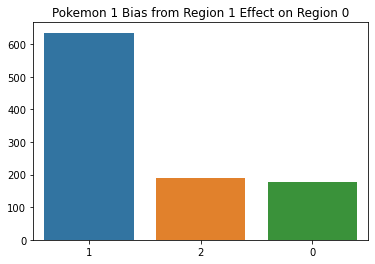

2. We set a heavy bias for 'Pokemon 1' at 'Region 2' where the contextual information is weighted very low



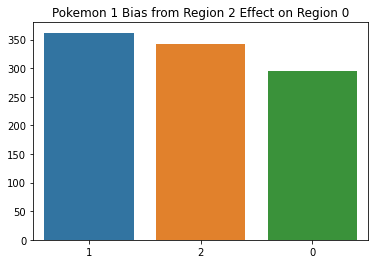

In [1025]:
high_weight_region = np.where(context_coef_matrix[0] == np.sort(context_coef_matrix[0])[-2])[0][0]
low_weight_region = np.where(context_coef_matrix[0] == np.sort(context_coef_matrix[0])[0])[0][0]

target = 1
region = 0

print("We will run two tests:\n")

test_regions = [high_weight_region, low_weight_region]
test_names = ["high", "low"]
idx = 1
for test, name in zip(test_regions, test_names):
    params = np.ones(shape=(num_regions, num_pokemon, 2))
    params[test, :, 1] = 100
    params[test, target, 0] = 10000

    answer = []
    for i in range(1000):
        ### SIMULATE SINGLE PATIENT BASED FLOW REQUEST ###
        request = [region, target] # the region and real pokemon ID associated with the request (irl pokemon ID unknown)
        request_region = request[0]
        request_pokemon = request[1]

        coeffs = context_coef_matrix[request_region].values

        # sample from entire parameter matrix for surrounding area
        samples = np.random.beta(params[:, :, 0], params[:, :, 1])

        # take the argmax of the weighted average for each pokemon
        answer.append(np.argmax(samples.T.dot(coeffs.T)))
    print(f"{idx}. We set a heavy bias for 'Pokemon {target}' at 'Region {test}' where the contextual information is weighted very {name}\n")
    idx += 1
    fig, ax = plt.subplots()
    sns.barplot(data = pd.DataFrame(pd.Series(answer).value_counts()).T, ax=ax)
    ax.set_title(f"Pokemon {target} Bias from Region {test} Effect on Region {region}")
    plt.show()

As we can see, the pokemon 1 bias counts for a lot more when it is coming from a region with a high coefficient weight.

### Demonstration Two: Taking Weighted Samples

Recall for every step in the TS algorithm:

1. Estimate univariate beta distributions (one for each Pokemon)
2. Sample from every beta distribution and select the pokemon with the maximum reward
3. Search for the selected Pokemon, update \\(\theta\\) and \\(X\\)

$$
  \theta = \left \{
  \begin{aligned}
    &(\alpha_{k,p}, \beta_{k,p}) + (r_t, 1-r_t), && \text{if}\ x_t = k, y_t = p \\
    &(\alpha_{k,p}, \beta_{k,p}), && \text{otherwise}
  \end{aligned} \right.
$$
<br><br>
$$
  X = \left \{
  \begin{aligned}
    &X+(r_t-X)\space\eta, && \text{if}\ \theta_{max}=(\theta^T \cdot X)_{max} \\
    &X, && \text{otherwise}
  \end{aligned} \right.
$$

where 

$X$ : the context coefficient matrix <br>
$\theta$ : estimated success probabilities <br>
$t$: current time step <br>
$p$: available regions <br>
$k$: available targets/actions (pokemon 0, 1, 2) <br>
$x_t$: the target selected/action taken <br>
$y_t$: the current region <br>
$r_t$: the reward of selected target (0 or 1) <br>
$\alpha$ : alpha parameter of the beta distribution <br>
$\beta$ : beta parameter of the beta distribution <br>
$\eta$ : context learning rate <br>

The sample shape is determined by (regions x pokemon): (4, 3)
and reflects the expected value for every pokemon for every region:



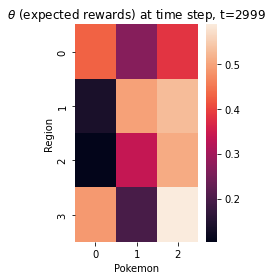

The contextual TS algorithm will sum these samples along axis 0 (regions) 
weighted by the distance to the selected region:



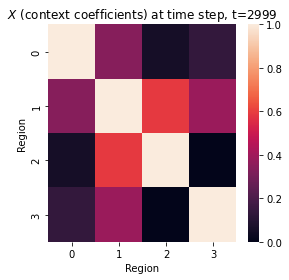

Every simulation round, a region is selected from which our algorithm receives a search request.
The selected region for this round is: 2
and so the coefficients will reflect that we weight region 2 by 1 and all other regions between 0-1 
according to their distance to region 2:

[0.05614041 0.58917249 1.         0.        ]

so the final expected value matrix is:

[0.20854324 0.64361233 0.84080672]



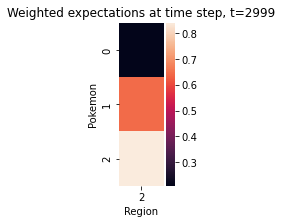

and pokemon 2 is selected this round


In [883]:
### SETUP THE SIMULATION PARAMETERS ###
# SIM SETUP
num_pokemon = 3
num_regions = 4
num_searches = 3000
np.random.seed(42)

lat_lng = get_city_center('Pewter')
lat_lng_max = get_max_lng_lat(lat_lng, km_max=50)
pokemon = get_distance_matrix(lat_lng_max, num_targets=num_pokemon, seed=12)
regions = get_distance_matrix(lat_lng_max, num_targets=num_regions, seed=10)

region_region_matrix = haversine_vectorized(regions, regions)
pokemon_region_matrix = haversine_vectorized(pokemon, regions)

ground_coef_matrix = pd.DataFrame((1 - pokemon_region_matrix/pokemon_region_matrix.max()))
context_coef_matrix = pd.DataFrame((1 - region_region_matrix/region_region_matrix.max()))

pokemon_expectations = np.random.random(num_pokemon) # an overall expected performance for each pokemon
spatial_pokemon_expectations = ground_coef_matrix * pokemon_expectations
dists = norm(loc=spatial_pokemon_expectations, scale=0.5)
samples = dists.rvs((num_searches, num_regions, num_pokemon))
true_charts = np.argmax(samples, axis=2)


# params represents the success (alpha) and failure (beta)
# of finding each pokemon based on historical performances

params = np.ones(shape=(num_regions, num_pokemon, 2))
answer = []
regret = []
successes = []

for sim_step in range(num_searches):
    
    ### SIMULATE SINGLE PATIENT BASED FLOW REQUEST ###
    region_id = random.randint(0, num_regions - 1)
    pokemon_id = true_charts[sim_step, region_id]

    # load coefficients for the received region ID
    coeffs = context_coef_matrix[region_id].values

    # sample from entire parameter matrix for surrounding area
    samples = np.random.beta(params[:, :, 0], params[:, :, 1])
    
    # calculate the mean of the distributions to determine regret
    current_dist = beta(params[:, :, 0], params[:, :, 1])
    max_exp = np.max(current_dist.mean().T.dot(coeffs.T))
    
    # take the argmax of the weighted average for each pokemon
    selected_pokemon = np.argmax(samples.T.dot(coeffs.T))
    selected_exp = np.max(samples.T.dot(coeffs.T)) 
    
    answer.append(selected_pokemon)
    regret.append(selected_exp - max_exp)
    
    ### TRACK SUCCESS/FAIL UPDATE PARAMS ###
    if pokemon_id == selected_pokemon:
        params[region_id, selected_pokemon, 0] += 1
        successes.append(1)
    else:
        params[region_id, selected_pokemon, 1] += 1
        successes.append(0)

print(f"The sample shape is determined by (regions x pokemon): {num_regions, num_pokemon}\nand reflects "\
     "the expected value for every pokemon for every region:\n")

fig, ax = plt.subplots(figsize=(num_pokemon, num_regions))
sns.heatmap(samples, ax=ax)
ax.set_title(r"$\theta$ (expected rewards) at time step, " + f"t={sim_step}")
ax.set_xlabel("Pokemon")
ax.set_ylabel("Region")
plt.tight_layout()
plt.show()

print(f"The contextual TS algorithm will sum these samples along axis 0 (regions) \nweighted by the "\
      "distance to the selected region:\n")

fig, ax = plt.subplots(figsize=(num_regions, num_regions))
sns.heatmap(context_coef_matrix, ax=ax)
ax.set_title(r"$X$ (context coefficients) at time step, " + f"t={sim_step}")
ax.set_xlabel("Region")
ax.set_ylabel("Region")
plt.tight_layout()
plt.show()

print("Every simulation round, a region is selected from which our algorithm receives a search request.")
region_id = random.randint(0, num_regions - 1)
print(f"The selected region for this round is: {region_id}")
coeffs = context_coef_matrix.iloc[region_id].values
print(f"and so the coefficients will reflect that we weight region {region_id} by 1 and all other"\
     f" regions between 0-1 \naccording to their distance to region {region_id}:")
print()
print(coeffs)
print()
print(f"so the final expected value matrix is:\n")
print(f"{samples.T.dot(coeffs)}\n")

fig, ax = plt.subplots(figsize=(1, num_pokemon))
sns.heatmap(samples.T.dot(coeffs).reshape(-1,1), ax=ax)
ax.set_title(r"Weighted expectations at time step, " + f"t={sim_step}")
ax.set_xlabel("Region")
ax.set_xticklabels(f"{region_id}")
ax.set_ylabel("Pokemon")
plt.show()
print(f"and pokemon {np.argmax(samples.T.dot(coeffs))} is selected this round")

### Demonstration Three: Updating \\(\theta\\) and \\(X\\)

We've shown how a pokemon is sampled with the contextualized univariate TS algorithm, but how are parameters updated when the chosen target is successful or not?

In the simple case, we update the beta parameters for the current region to reflect this result. However, we would like to also update the contextual weighting matrix

$$
  X = \left \{
  \begin{aligned}
    &X+(r_t-X)\space\eta, && \text{if}\ \theta_{max}=(\theta^T \cdot X)_{max} \\
    &X, && \text{otherwise}
  \end{aligned} \right.
$$

where $r_t$, the reward of the action taken, is $0$ when the target is incorrect and $1$ otherwise.

In this case, let's assume the answer chosen by the algorithm is _incorrect_ so $r_t = 0$


First we check where in the samples the incorrectly selected pokemon is weighted highest


In [884]:
np.argmax(samples, axis=1) == np.argmax(samples.T.dot(coeffs))

array([False,  True,  True,  True])

We turn this array of booleans into a region index

In [885]:
to_reweight = np.argwhere(np.argmax(samples, axis=1) == np.argmax(samples.T.dot(coeffs)))
# we don't want to update the diagonal
to_reweight = to_reweight[to_reweight != region_id]
to_reweight

array([1, 3])

We'll specify a learning weight

In [886]:
learning_rate = 0.2

And update our coefficients

Text(0.5, 1.0, 'After')

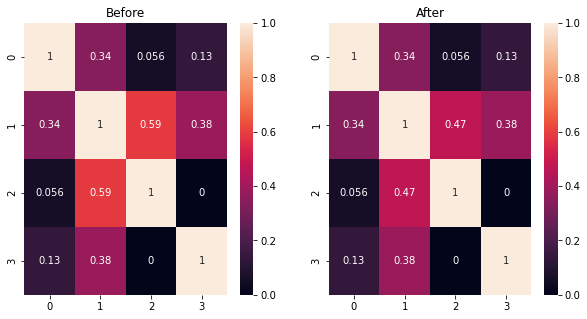

In [887]:
# remove 10% of the difference between the current weight and 0
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
sns.heatmap(context_coef_matrix, ax=ax[0], annot=True)
ax[0].set_title("Before")
context_coef_matrix.loc[to_reweight.reshape(-1), region_id] = (coeffs[to_reweight] - \
   ((coeffs[to_reweight] - 0) * learning_rate)).reshape(-1)
context_coef_matrix.loc[region_id, to_reweight.reshape(-1)] = (coeffs[to_reweight] - \
   ((coeffs[to_reweight] - 0) * learning_rate)).reshape(-1)
sns.heatmap(context_coef_matrix, ax=ax[1], annot=True)
ax[1].set_title("After")

We'll take the same process when we have a successful match, and reward the coefficients that helped us get that correct answer

$$
  X = \left \{
  \begin{aligned}
    &X+(r_t-X)\space\alpha, && \text{if}\ \theta_{max}=\theta_{max}^T \cdot X \\
    &X, && \text{otherwise}
  \end{aligned} \right.
$$

where

$$
r_t = 1
$$

In [888]:
# the reward formula simplifies to
((1 - coeffs[to_reweight]) * learning_rate)

array([0.1057324, 0.2      ])

In [889]:
# add 10% of the difference between the current weight and 1
coeffs[to_reweight] + ((1 - coeffs[to_reweight]) * learning_rate)

array([0.57707039, 0.2       ])

The sample shape is determined by (regions x pokemon): (4, 3)
and reflects the expected value for every pokemon for every region:



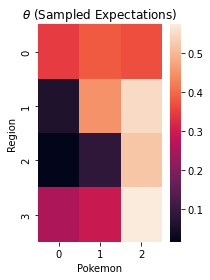

The contextual TS algorithm will sum these samples along axis 0 (regions) 
weighted by the distance to the selected region:



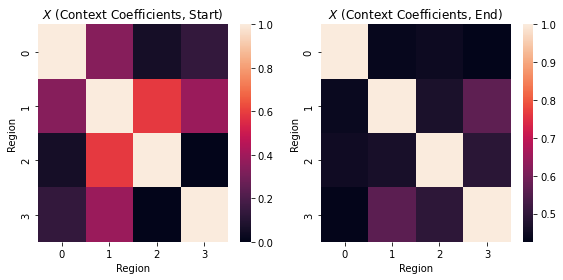

Every simulation round, a region is selected from which our algorithm receives a search request.
The selected region for this round is: 3
and so the coefficients will reflect that we weight region 3 by 1 and all other regions between 0-1 
according to their distance to region 3:

[0.42957413 0.56116383 0.49474465 1.        ]

so the final expected value matrix is:

[0.44658981 0.75022983 1.29657116]



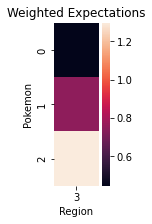

and pokemon 2 is selected this round


In [890]:
### SETUP THE SIMULATION PARAMETERS ###
# SIM SETUP
num_pokemon = 3
num_regions = 4
num_searches = 3000
learning_rate = 0.01
np.random.seed(42)

lat_lng = get_city_center('Pewter')
lat_lng_max = get_max_lng_lat(lat_lng, km_max=50)
pokemon = get_distance_matrix(lat_lng_max, num_targets=num_pokemon, seed=12)
regions = get_distance_matrix(lat_lng_max, num_targets=num_regions, seed=10)

region_region_matrix = haversine_vectorized(regions, regions)
pokemon_region_matrix = haversine_vectorized(pokemon, regions)

ground_coef_matrix = pd.DataFrame((1 - pokemon_region_matrix/pokemon_region_matrix.max()))
context_coef_matrix = pd.DataFrame((1 - region_region_matrix/region_region_matrix.max()))
before = context_coef_matrix.copy()

pokemon_expectations = np.random.random(num_pokemon) # an overall expected performance for each pokemon
spatial_pokemon_expectations = ground_coef_matrix * pokemon_expectations
dists = norm(loc=spatial_pokemon_expectations, scale=0.5)
samples = dists.rvs((num_searches, num_regions, num_pokemon))
true_charts = np.argmax(samples, axis=2)


# params represents the success (alpha) and failure (beta)
# of finding each pokemon based on historical performances

params = np.ones(shape=(num_regions, num_pokemon, 2))
init_params = params.copy()
answer = []
regret = []
successes = []

for sim_step in range(num_searches):
    
    ### SIMULATE SINGLE PATIENT BASED FLOW REQUEST ###
    region_id = random.randint(0, num_regions - 1)
    pokemon_id = true_charts[sim_step, region_id]

    # load coefficients for the received region ID
    coeffs = context_coef_matrix[region_id].values

    # sample from entire parameter matrix for surrounding area
    samples = np.random.beta(params[:, :, 0], params[:, :, 1])
    
    # calculate the mean of the distributions to determine regret
    current_dist = beta(params[:, :, 0], params[:, :, 1])
    max_exp = np.max(current_dist.mean().T.dot(coeffs.T))
    
    # take the argmax of the weighted average for each pokemon
    selected_pokemon = np.argmax(samples.T.dot(coeffs.T))
    selected_exp = np.max(samples.T.dot(coeffs.T)) 
    
    answer.append(selected_pokemon)
    regret.append(selected_exp - max_exp)
    
    to_reweight = np.argwhere(np.argmax(samples, axis=1) == selected_pokemon)
    to_reweight = to_reweight[to_reweight != region_id]
    ### TRACK SUCCESS/FAIL UPDATE PARAMS ###
    if pokemon_id == selected_pokemon:
        context_coef_matrix.loc[to_reweight.reshape(-1), region_id] = (coeffs[to_reweight] + \
           ((1 - coeffs[to_reweight]) * learning_rate)).reshape(-1)
        context_coef_matrix.loc[region_id, to_reweight.reshape(-1)] = (coeffs[to_reweight] + \
           ((1 - coeffs[to_reweight]) * learning_rate)).reshape(-1)
        params[region_id, selected_pokemon, 0] += 1
        successes.append(1)
    else:
        context_coef_matrix.loc[to_reweight.reshape(-1), region_id] = (coeffs[to_reweight] - \
           ((coeffs[to_reweight] - 0) * learning_rate)).reshape(-1)
        context_coef_matrix.loc[region_id, to_reweight.reshape(-1)] = (coeffs[to_reweight] - \
           ((coeffs[to_reweight] - 0) * learning_rate)).reshape(-1)
        params[region_id, selected_pokemon, 1] += 1
        successes.append(0)
        
print(f"The sample shape is determined by (regions x pokemon): {num_regions, num_pokemon}\nand reflects "\
     "the expected value for every pokemon for every region:\n")

fig, ax = plt.subplots(figsize=(num_pokemon, num_regions))
sns.heatmap(samples, ax=ax)
ax.set_title(r"$\theta$ (Sampled Expectations)")
ax.set_xlabel("Pokemon")
ax.set_ylabel("Region")
plt.tight_layout()
plt.show()
fig.savefig("figures/pokemon1.png")

print(f"The contextual TS algorithm will sum these samples along axis 0 (regions) \nweighted by the "\
      "distance to the selected region:\n")

fig, ax = plt.subplots(1, 2, figsize=(num_regions*2, num_regions))
sns.heatmap(before, ax=ax[0])
sns.heatmap(context_coef_matrix, ax=ax[1])
ax[0].set_title(r"$X$ (Context Coefficients, Start)")
ax[0].set_xlabel("Region")
ax[0].set_ylabel("Region")
ax[1].set_title(r"$X$ (Context Coefficients, End)")
ax[1].set_xlabel("Region")
ax[1].set_ylabel("Region")

plt.tight_layout()
plt.show()
fig.savefig("figures/pokemon2.png")

print("Every simulation round, a region is selected from which our algorithm receives a search request.")
region_id = random.randint(0, num_regions - 1)
print(f"The selected region for this round is: {region_id}")
coeffs = context_coef_matrix.iloc[region_id].values
print(f"and so the coefficients will reflect that we weight region {region_id} by 1 and all other"\
     f" regions between 0-1 \naccording to their distance to region {region_id}:")
print()
print(coeffs)
print()
print(f"so the final expected value matrix is:\n")
print(f"{samples.T.dot(coeffs)}\n")

fig, ax = plt.subplots(figsize=(1, num_pokemon))
sns.heatmap(samples.T.dot(coeffs).reshape(-1,1), ax=ax)
ax.set_title(r"Weighted Expectations")
ax.set_xlabel("Region")
ax.set_xticklabels(f"{region_id}")
ax.set_ylabel("Pokemon")
plt.show()
fig.savefig("figures/pokemon3.png")
print(f"and pokemon {np.argmax(samples.T.dot(coeffs))} is selected this round")

We have this notion of regret in TS that is the difference between the expected value of the action taken by the algorithm and the maximum expected value the algorithm COULD have taken

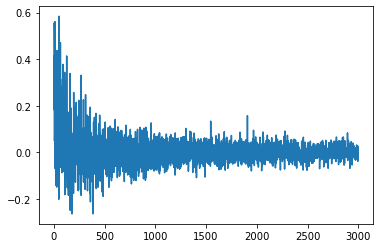

In [891]:
plt.plot(regret)

We can also look at the learned beta distributions of our algorithm

Text(33.0, 0.5, ' region')

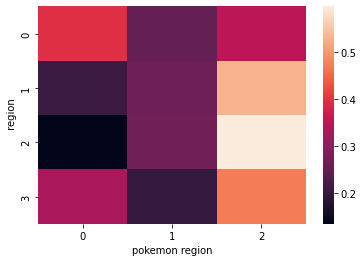

In [892]:
est_pokemon_expectations = params[:, :, 0] / (params[:, :, 0] + params[:, :, 1])
reweighted_est_pokemon_expectations = (est_pokemon_expectations / 
    np.tile(est_pokemon_expectations.sum(axis=1), num_pokemon)
    .reshape(num_pokemon, num_regions).T)

fig, ax = plt.subplots()
sns.heatmap(reweighted_est_pokemon_expectations)
ax.set_xlabel("pokemon region")
ax.set_ylabel(" region")

We can compare this "learned" feature space with the ground truth

Text(33.0, 0.5, 'region')

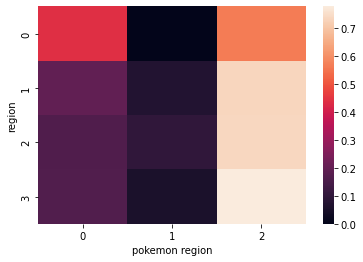

In [893]:
# reweight so that each region sums to 1
reweighted_spatial_pokemon_expectations = (spatial_pokemon_expectations / 
    np.tile(spatial_pokemon_expectations.sum(axis=1).values, num_pokemon)
    .reshape(num_pokemon, num_regions).T)

fig, ax = plt.subplots()
sns.heatmap(reweighted_spatial_pokemon_expectations)
ax.set_xlabel("pokemon region")
ax.set_ylabel("region")

In [894]:
print(f"successes: {params[:,:,0].sum()/params.sum()*100:.1f}%")
print(f"failures: {params[:,:,1].sum()/params.sum()*100:.1f}%")

successes: 49.8%
failures: 50.2%


In [895]:
print(f"success from random guessing: {1/num_pokemon*100:.1f}%")

success from random guessing: 33.3%


In [896]:
regret_ts_context = regret
successes_ts_context = successes

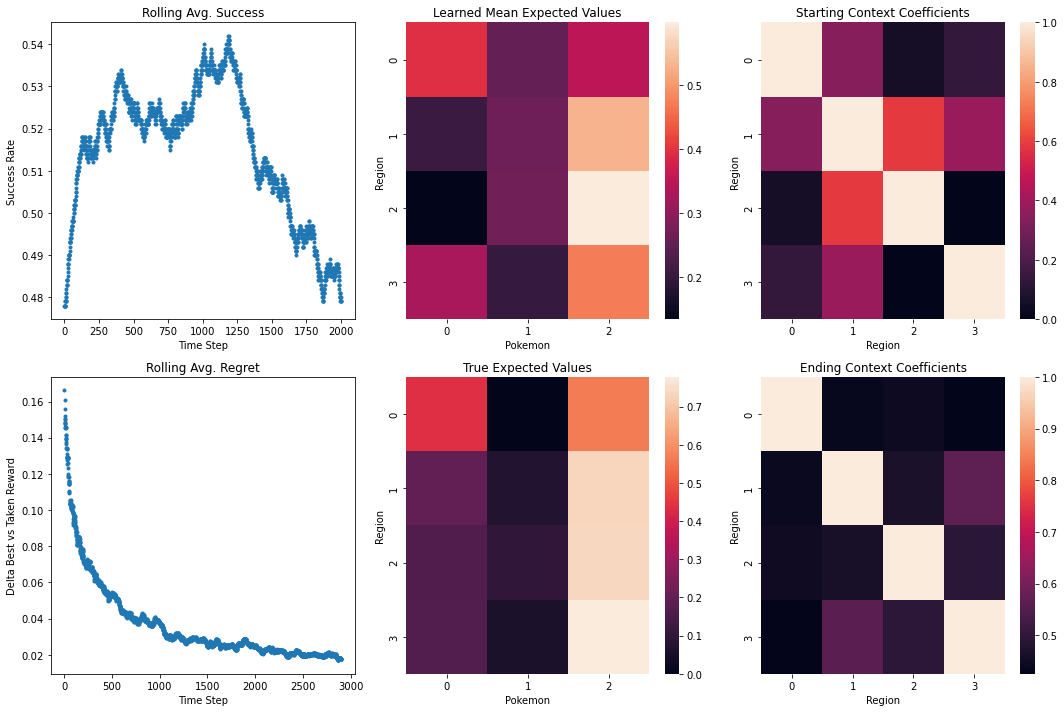

In [897]:
fig, ax = plt.subplots(2, 3, figsize=(15, 10))
ax[1, 0].plot(moving_average(np.abs(regret), 100), ls='', marker='.')
ax[0, 0].plot(moving_average(np.abs(successes), 1000), ls='', marker='.')
sns.heatmap(reweighted_est_pokemon_expectations, ax=ax[0, 1])
sns.heatmap(reweighted_spatial_pokemon_expectations, ax=ax[1, 1])
sns.heatmap(before, ax=ax[0, 2])
sns.heatmap(context_coef_matrix, ax=ax[1, 2])

ax[1, 0].set_title("Rolling Avg. Regret")
ax[0, 0].set_title("Rolling Avg. Success")
ax[0, 1].set_title("Learned Mean Expected Values")
ax[1, 1].set_title("True Expected Values")
ax[0, 2].set_title("Starting Context Coefficients")
ax[1, 2].set_title("Ending Context Coefficients")
ax[0, 0].set_xlabel("Time Step")
ax[0, 0].set_ylabel("Success Rate")
ax[1, 0].set_xlabel("Time Step")
ax[1, 0].set_ylabel("Delta Best vs Taken Reward")
ax[0, 1].set_xlabel("Pokemon")
ax[0, 1].set_ylabel("Region")
ax[1, 1].set_xlabel("Pokemon")
ax[1, 1].set_ylabel("Region")
ax[0, 2].set_xlabel("Region")
ax[0, 2].set_ylabel("Region")
ax[1, 2].set_xlabel("Region")
ax[1, 2].set_ylabel("Region")
plt.tight_layout()
fig.savefig("figures/pokemon4.png")

## MultiArmedBandit

We can demonstrate now how we leverage this context in a search. Let's create the main class.

In [980]:
class MultiArmedBandit:
    
    def __init__(self,
                 num_targets=8, 
                 num_regions=5):
        
        self.num_targets = num_targets
        self.num_regions = num_regions
    
    def make_truth(self, 
                   region_target_matrix,
                   region_region_matrix,
                   distance_strength=1,
                   starting_context_scale=0,
                   noise=1,
                   seed=12,
                   norm_scale=1,
                   num_retrievals=1000,
                   learned_params=None,
                   true_charts=None):
        """
        starting_context_scale ranges -1, 1. 0: standard linear distance weighting, 1: all coefs are 1
        -1: all coeffs are 0. 
        # noise = 1 # should be randomized vector if not 1, will "blur" site_expectations
        num_retrievals = 100000 # the number of retrievals per postal code
        larger norm scale will give more equal weighting between sites
        """
        self.region_target_matrix = region_target_matrix
        self.region_region_matrix = region_region_matrix
        self.num_retrievals = num_retrievals
        self.norm_scale = norm_scale
        
        if seed:
            self.seed = seed
            np.random.seed(seed)
            
        num_targets = self.num_targets
        num_regions = self.num_regions
        
        # used for weighting of nearyby region samples
        frac = 1 - (region_region_matrix / (region_region_matrix.max()))
        if starting_context_scale >= 0:
            adjust = (1 - frac) * starting_context_scale
        elif starting_context_scale < 0:
            adjust = frac * starting_context_scale
        scale = frac + adjust
        np.fill_diagonal(scale, 1)
        context_coef_matrix = pd.DataFrame(scale)
        
        # we set the ground truth
        if true_charts is None:
            # an overall expected performance for each site
            site_expectations = np.random.random(num_targets) 
            ground_coef_matrix = pd.DataFrame((1 - region_target_matrix/region_target_matrix.max() 
                                               * distance_strength))
            spatial_target_expectations = ground_coef_matrix * site_expectations * noise
            dists = norm(loc=spatial_target_expectations, scale=norm_scale)
            samples = dists.rvs((num_retrievals, num_regions, num_targets))
            true_charts = np.argmax(samples, axis=2)
            
            
            true_probs = []
            for i in range(num_regions):
                pop_site = np.bincount(true_charts[:,i]).argmax()
                exp = (true_charts[:,i] == pop_site).sum() / true_charts.shape[0]
                true_probs.append(exp)
                
            true_charts = pd.DataFrame(true_charts).melt().sample(frac=1)[:num_retrievals].values
                        
        else:
            spatial_target_expectations = pd.DataFrame(pd.DataFrame(true_charts).value_counts([0, 1]), columns=['count']).reset_index()\
                .pivot(index=0, columns=1, values='count')
            spatial_target_expectations = spatial_target_expectations.fillna(0)
            true_probs = max(spatial_target_expectations.sum(axis=0) / spatial_target_expectations.sum().sum())
            
        self.spatial_target_expectations = spatial_target_expectations
        self.true_probs = true_probs  
        self.context_coef_matrix = context_coef_matrix
        self.original_context = context_coef_matrix.copy()
        self.true_charts = true_charts
        
        if learned_params is None:
            self.learned_params = np.ones(shape=(num_regions, num_targets, 2))
        else:
            self.learned_params = learned_params
            
    def run_ts(self,
               with_context=True,
               distance_heuristic=False,
               learning_rate=0.01):
        
        ### SETUP THE SIMULATION PARAMETERS ###
        num_regions = self.num_regions
        num_targets = self.num_targets
        num_retrievals = self.num_retrievals
        true_charts = self.true_charts
        context_coef_matrix = self.context_coef_matrix
        params = self.learned_params
        
        answer = []
        regret = []
        successes = []

        for sim_step in range(num_retrievals):

            ### SIMULATE SINGLE PATIENT BASED FLOW REQUEST ###
            region_id = true_charts[sim_step, 0]
            target_id = true_charts[sim_step, 1]

            # load coefficients for the received postal ID
            coeffs = context_coef_matrix.iloc[region_id].values

            # sample from entire parameter matrix for surrounding area
            if with_context:
                samples = np.random.beta(params[:, :, 0], params[:, :, 1])
                selected_site = np.argmax(samples.T.dot(coeffs.T))
                selected_exp = np.max(samples.T.dot(coeffs.T)) 
                
                # calculate max exp
                current_dist = beta(params[:, :, 0], params[:, :, 1])
                max_exp = np.max(current_dist.mean().T.dot(coeffs.T))
                
                to_reweight = np.argwhere(np.argmax(samples, axis=1) == selected_site)
                # do not update the diagonal
                to_reweight = to_reweight[to_reweight != region_id]
                
            else:  
                current_dist = beta(params[region_id, :, 0], params[region_id, :, 1])
    
                # not based on sampling, based on distance, but uses beta means for regret comparison
                if distance_heuristic:
                    selected_site = np.argmin(self.region_target_matrix[region_id]) 
                    selected_exp = current_dist.mean()[selected_site] 
                    
                # otherwise we do a non context TS selection
                else:         
                    samples = np.random.beta(params[region_id, :, 0], params[region_id, :, 1])
                    selected_site = np.argmax(samples)
                    selected_exp = np.max(samples)
                    
                max_exp = np.max(current_dist.mean())

            answer.append(selected_site)
            regret.append(max_exp - selected_exp)

            ### TRACK SUCCESS/FAIL UPDATE PARAMS ###
            if target_id == selected_site:
                if with_context:
                    context_coef_matrix.loc[to_reweight.reshape(-1), region_id] = (coeffs[to_reweight] + \
                       ((1 - coeffs[to_reweight]) * learning_rate)).reshape(-1)
                    context_coef_matrix.loc[region_id, to_reweight.reshape(-1)] = (coeffs[to_reweight] + \
                       ((1 - coeffs[to_reweight]) * learning_rate)).reshape(-1)
                params[region_id, selected_site, 0] += 1
                successes.append(1)
            else:
                if with_context:
                    context_coef_matrix.loc[to_reweight.reshape(-1), region_id] = (coeffs[to_reweight] - \
                       ((coeffs[to_reweight] - 0) * learning_rate/num_targets)).reshape(-1)
                    context_coef_matrix.loc[region_id, to_reweight.reshape(-1)] = (coeffs[to_reweight] - \
                       ((coeffs[to_reweight] - 0) * learning_rate/num_targets)).reshape(-1)
                params[region_id, selected_site, 1] += 1
                successes.append(0)
        
        self.answer = answer
        self.regret = regret
        self.successes = successes
        self.learned_params = params
        self.rolling_success = self.moving_average(successes, int(num_retrievals/20))
        self.rolling_regret = self.moving_average(regret, int(num_retrievals/20))
        
    def show_heatmap(self, data='ground', **kwargs):
        
        num_targets = self.num_targets
        num_regions = self.num_regions
        
        # fig, ax = plt.subplots(figsize=(5,5))
        
        if data == 'ground':
            sns.heatmap(self.spatial_target_expectations, **kwargs)
            # ax.set_xlabel("site postal code")
            # ax.set_ylabel("patient postal code")
        
        elif data == 'learned':
            params = self.learned_params
            est_target_expectations = params[:, :, 0] / (params[:, :, 0] + params[:, :, 1])
            reweighted_est_target_expectations = (est_target_expectations / 
                np.tile(est_target_expectations.sum(axis=1), num_targets)
                .reshape(num_targets, num_regions).T)
            sns.heatmap(reweighted_est_target_expectations, **kwargs)
            # ax.set_xlabel("site postal code")
            # ax.set_ylabel("patient postal code")
            
        # return fig
            
    def moving_average(self, x, w):
        return np.convolve(x, np.ones(w), 'valid') / w

### Pewter City Sims

We can now after packaging our code, compare contextualized and non contextualized TS methods with a variety of hyperparameter settings

In [982]:
### SETUP THE GROUND TRUTH PARAMETER ###
num_pokemon = 3
num_regions = 4
num_searches = 30000
np.random.seed(42)

### SETUP THE SIMULATION PARAMETERS ###
starting_context_scale = -0.9
learning_rate = 0.01


lat_lng = get_city_center('Pewter')
lat_lng_max = get_max_lng_lat(lat_lng, km_max=50)
pokemon = get_distance_matrix(lat_lng_max, num_targets=num_pokemon, seed=12)
regions = get_distance_matrix(lat_lng_max, num_targets=num_regions, seed=10)

region_region_matrix = haversine_vectorized(regions, regions)
pokemon_region_matrix = haversine_vectorized(pokemon, regions)

# run w/o context
model = MultiArmedBandit(num_targets=num_pokemon,
                         num_regions=num_regions)

model.make_truth(pokemon_region_matrix,
                 region_region_matrix,
                 seed=1, 
                 norm_scale=single_site_dominance, 
                 num_retrievals=num_searches,
                 starting_context_scale=starting_context_scale)

model.run_ts(with_context=False,
             learning_rate=learning_rate)

model1 = model

# run with context
model = MultiArmedBandit(num_targets=num_pokemon,
                         num_regions=num_regions)

model.make_truth(pokemon_region_matrix,
                 region_region_matrix,
                 seed=1, 
                 norm_scale=single_site_dominance, 
                 num_retrievals=num_searches,
                 starting_context_scale=starting_context_scale)

model.run_ts(with_context=True,
             learning_rate=learning_rate)

model2 = model

# run w/o context
model = MultiArmedBandit(num_targets=num_pokemon,
                         num_regions=num_regions)

model.make_truth(pokemon_region_matrix,
                 region_region_matrix,
                 seed=3, 
                 norm_scale=single_site_dominance, 
                 num_retrievals=num_searches,
                 starting_context_scale=starting_context_scale)

model.run_ts(with_context=False,
             distance_heuristic=True,
             learning_rate=learning_rate)

model3 = model

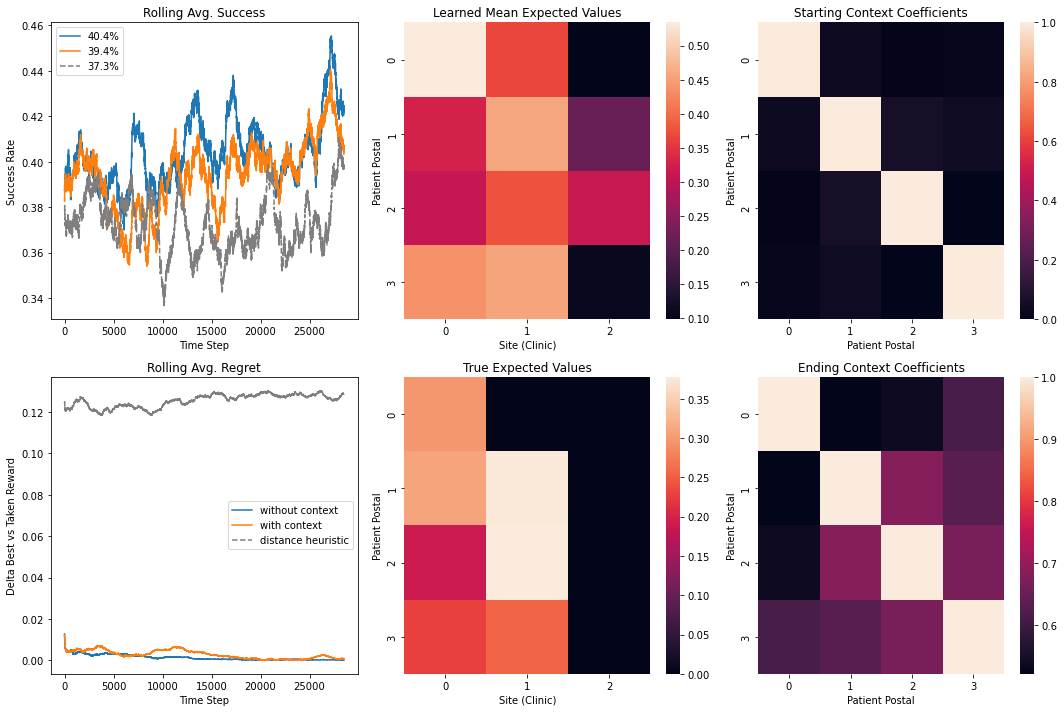

In [983]:
fig, ax = plt.subplots(2, 3, figsize=(15, 10))

ax[1, 0].plot(np.abs(model1.rolling_regret), label="without context")
tot_success = sum(model1.successes)/len(model1.successes)
ax[0, 0].plot(model1.rolling_success, label=f"{tot_success*100:.1f}%")

ax[1, 0].plot(np.abs(model2.rolling_regret), label="with context")
tot_success = sum(model2.successes)/len(model2.successes)
ax[0, 0].plot(model2.rolling_success, label=f"{tot_success*100:.1f}%")

ax[1, 0].plot(np.abs(model3.rolling_regret), label="distance heuristic", ls='--', c='tab:grey')
tot_success = sum(model3.successes)/len(model3.successes)
ax[0, 0].plot(model3.rolling_success, label=f"{tot_success*100:.1f}%", ls='--', c='tab:grey')

model2.show_heatmap(data='learned', ax=ax[0, 1])
model2.show_heatmap(data='ground', ax=ax[1, 1])
sns.heatmap(model2.original_context, ax=ax[0, 2])
sns.heatmap(model2.context_coef_matrix, ax=ax[1, 2])

ax[0, 0].legend()
ax[1, 0].legend()
ax[1, 0].set_title("Rolling Avg. Regret")
ax[0, 0].set_title("Rolling Avg. Success")
ax[0, 1].set_title("Learned Mean Expected Values")
ax[1, 1].set_title("True Expected Values")
ax[0, 2].set_title("Starting Context Coefficients")
ax[1, 2].set_title("Ending Context Coefficients")
ax[0, 0].set_xlabel("Time Step")
ax[0, 0].set_ylabel("Success Rate")
ax[1, 0].set_xlabel("Time Step")
ax[1, 0].set_ylabel("Delta Best vs Taken Reward")
ax[0, 1].set_xlabel("Site (Clinic)")
ax[0, 1].set_ylabel("Patient Postal")
ax[1, 1].set_xlabel("Site (Clinic)")
ax[1, 1].set_ylabel("Patient Postal")
ax[0, 2].set_xlabel("Patient Postal")
ax[0, 2].set_ylabel("Patient Postal")
ax[1, 2].set_xlabel("Patient Postal")
ax[1, 2].set_ylabel("Patient Postal")
plt.tight_layout()

In [988]:
### SETUP THE GROUND TRUTH PARAMETER ###
num_pokemon = 10
num_regions = 20
num_searches = 3000
np.random.seed(42)
single_site_dominance = 0.1

### SETUP THE SIMULATION PARAMETERS ###
starting_context_scale = -0.9
learning_rate = 0.01


lat_lng = get_city_center('Pewter')
lat_lng_max = get_max_lng_lat(lat_lng, km_max=50)
pokemon = get_distance_matrix(lat_lng_max, num_targets=num_pokemon, seed=12)
regions = get_distance_matrix(lat_lng_max, num_targets=num_regions, seed=10)

region_region_matrix = haversine_vectorized(regions, regions)
pokemon_region_matrix = haversine_vectorized(pokemon, regions)

# run w/o context
model = MultiArmedBandit(num_targets=num_pokemon,
                         num_regions=num_regions)

model.make_truth(pokemon_region_matrix,
                 region_region_matrix,
                 seed=1, 
                 norm_scale=single_site_dominance, 
                 num_retrievals=num_searches,
                 starting_context_scale=starting_context_scale)

model.run_ts(with_context=False,
             learning_rate=learning_rate)

model1 = model

# run with context
model = MultiArmedBandit(num_targets=num_pokemon,
                         num_regions=num_regions)

model.make_truth(pokemon_region_matrix,
                 region_region_matrix,
                 seed=1, 
                 norm_scale=single_site_dominance, 
                 num_retrievals=num_searches,
                 starting_context_scale=starting_context_scale)

model.run_ts(with_context=True,
             learning_rate=learning_rate)

model2 = model

# run w/o context
model = MultiArmedBandit(num_targets=num_pokemon,
                         num_regions=num_regions)

model.make_truth(pokemon_region_matrix,
                 region_region_matrix,
                 seed=3, 
                 norm_scale=single_site_dominance, 
                 num_retrievals=num_searches,
                 starting_context_scale=starting_context_scale)

model.run_ts(with_context=False,
             distance_heuristic=True,
             learning_rate=learning_rate)

model3 = model

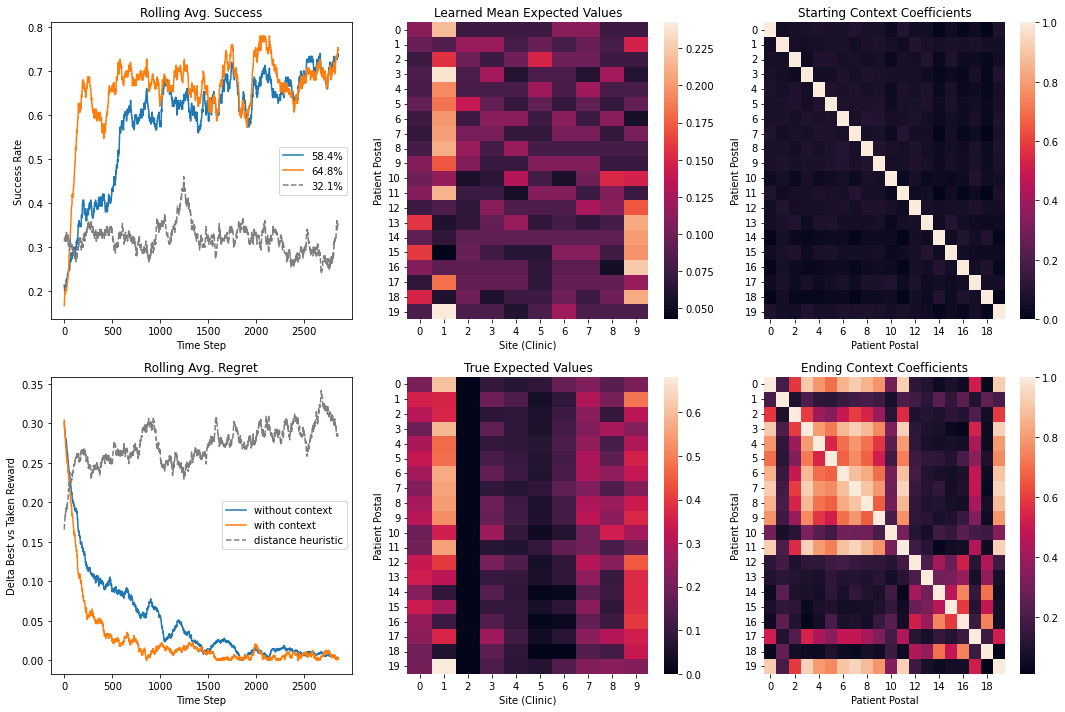

In [989]:
fig, ax = plt.subplots(2, 3, figsize=(15, 10))

ax[1, 0].plot(np.abs(model1.rolling_regret), label="without context")
tot_success = sum(model1.successes)/len(model1.successes)
ax[0, 0].plot(model1.rolling_success, label=f"{tot_success*100:.1f}%")

ax[1, 0].plot(np.abs(model2.rolling_regret), label="with context")
tot_success = sum(model2.successes)/len(model2.successes)
ax[0, 0].plot(model2.rolling_success, label=f"{tot_success*100:.1f}%")

ax[1, 0].plot(np.abs(model3.rolling_regret), label="distance heuristic", ls='--', c='tab:grey')
tot_success = sum(model3.successes)/len(model3.successes)
ax[0, 0].plot(model3.rolling_success, label=f"{tot_success*100:.1f}%", ls='--', c='tab:grey')

model2.show_heatmap(data='learned', ax=ax[0, 1])
model2.show_heatmap(data='ground', ax=ax[1, 1])
sns.heatmap(model2.original_context, ax=ax[0, 2])
sns.heatmap(model2.context_coef_matrix, ax=ax[1, 2])

ax[0, 0].legend()
ax[1, 0].legend()
ax[1, 0].set_title("Rolling Avg. Regret")
ax[0, 0].set_title("Rolling Avg. Success")
ax[0, 1].set_title("Learned Mean Expected Values")
ax[1, 1].set_title("True Expected Values")
ax[0, 2].set_title("Starting Context Coefficients")
ax[1, 2].set_title("Ending Context Coefficients")
ax[0, 0].set_xlabel("Time Step")
ax[0, 0].set_ylabel("Success Rate")
ax[1, 0].set_xlabel("Time Step")
ax[1, 0].set_ylabel("Delta Best vs Taken Reward")
ax[0, 1].set_xlabel("Site (Clinic)")
ax[0, 1].set_ylabel("Patient Postal")
ax[1, 1].set_xlabel("Site (Clinic)")
ax[1, 1].set_ylabel("Patient Postal")
ax[0, 2].set_xlabel("Patient Postal")
ax[0, 2].set_ylabel("Patient Postal")
ax[1, 2].set_xlabel("Patient Postal")
ax[1, 2].set_ylabel("Patient Postal")
plt.tight_layout()

### Confidence Intervals

In [1035]:
# SIM SETUP
rounds = 10

### SETUP THE GROUND TRUTH PARAMETER ###
num_pokemon = 10
num_regions = 20
num_searches = 3000
np.random.seed(42)
single_site_dominance = 0.1

### SETUP THE SIMULATION PARAMETERS ###
starting_context_scale = -0.9
learning_rate = 0.01

# RUN SIM
for i in range(rounds):

    lat_lng_max = get_max_lng_lat(lat_lng, km_max=50)
    pokemon = get_distance_matrix(lat_lng_max, num_targets=num_pokemon)
    regions = get_distance_matrix(lat_lng_max, num_targets=num_regions)

    # ground truth
    region_region_matrix = haversine_vectorized(regions, regions)
    pokemon_region_matrix = haversine_vectorized(pokemon, regions)

    model = MultiArmedBandit(num_targets=num_pokemon,
                             num_regions=num_regions)

    model.make_truth(pokemon_region_matrix,
                 region_region_matrix,
                 norm_scale=single_site_dominance, 
                 num_retrievals=num_searches,
                 distance_strength=distance_strength)

    # run w/o context
    model.run_ts(with_context=False)
    regret_ts = model.rolling_regret
    success_ts = model.rolling_success

    # run with context
    model.run_ts(with_context=True,
                 learning_rate=learning_rate)
    regret_ts_context = model.rolling_regret
    success_ts_context = model.rolling_success
    
    if i == 0:
        regrets = np.array([regret_ts, regret_ts_context])
        successes = np.array([success_ts, success_ts_context])
    else:
        regrets = np.concatenate((regrets, np.array([regret_ts, regret_ts_context])))
        successes = np.concatenate((successes, np.array([success_ts, success_ts_context])))
successes = successes.reshape((rounds, 2, -1))
regrets = regrets.reshape((rounds, 2, -1))

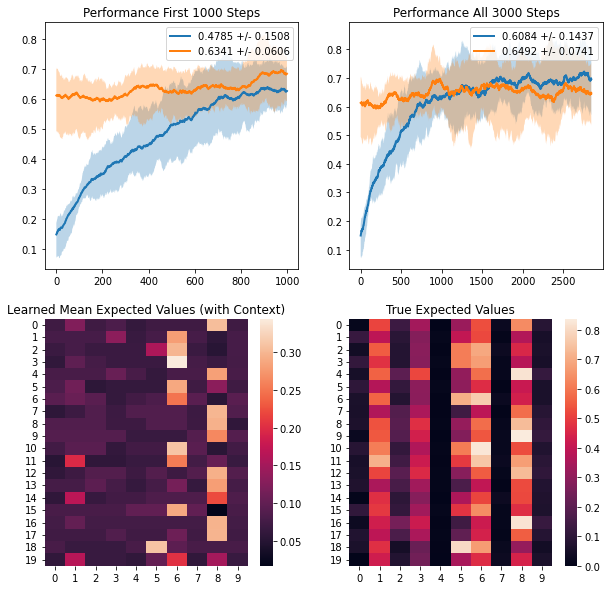

In [ ]:
# i = 0 w/o context
# i = 1 w/ context

fig, ax = plt.subplots(2, 2, figsize=(10, 10))
model.show_heatmap(data='learned', ax=ax[1, 0])
model.show_heatmap(data='ground', ax=ax[1, 1])

for i in range(2):
    line = successes[:, i, :1000].mean(axis=0)
    over_line = np.percentile(successes[:, i, :1000], axis=0, q=97.5)
    under_line = np.percentile(successes[:, i, :1000], axis=0, q=2.5)
    ax[0, 0].plot(line, linewidth=2, label=f"{successes[:, i, :1000].mean():.4f} +/- {successes[:, i, :1000].std():.4f}")
    ax[0, 0].fill_between(range(line.shape[0]), under_line,
                      over_line, alpha=.3)
ax[0, 0].legend()
ax[0, 0].set_title("Performance First 1000 Steps")
for i in range(2):
    line = successes[:, i, :].mean(axis=0)
    over_line = np.percentile(successes[:, i, :], axis=0, q=97.5)
    under_line = np.percentile(successes[:, i, :], axis=0, q=2.5)
    ax[0, 1].plot(line, linewidth=2, label=f"{successes[:, i, :].mean():.4f} +/- {successes[:, i, :].std():.4f}")
    ax[0, 1].fill_between(range(line.shape[0]), under_line,
                      over_line, alpha=.3)
ax[0, 1].legend()
ax[0, 1].set_title(f"Performance All {num_searches} Steps")
ax[1, 0].set_title("Learned Mean Expected Values (with Context)")
ax[1, 1].set_title("True Expected Values")
plt.show()

# fig.savefig("figures/pewter2.png")